In [1]:
# libraires
import cv2
import numpy as np
from ultralytics import YOLO
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

C:\Users\sirom\AppData\Roaming\Python\Python310\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


#### Load Models

In [3]:
# Load YOLO detection model
yolo_model = YOLO("yolov8s.pt")  # Replace with your YOLO model path

# Load classification model, you can run notebook and save model and use it (check step 2)
classification_model = load_model('dog_classification_model.h5')

<br>

#### Classification labels

In [5]:
species_list = ['afghan_hound', 'african_hunting_dog', 'airedale', 'basenji', 'basset', 'beagle', 
                'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 
                'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 
                'borzoi', 'boston_bull', 'bouvier_des_flandres', 'brabancon_griffon', 'bull_mastiff', 
                'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chow', 'clumber', 'cocker_spaniel', 
                'collie', 'curly-coated_retriever', 'dhole', 'dingo', 'doberman', 'english_foxhound', 
                'english_setter', 'entlebucher', 'flat-coated_retriever', 'german_shepherd', 
                'german_short-haired_pointer', 'golden_retriever', 'gordon_setter', 'great_dane', 
                'great_pyrenees', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 
                'irish_water_spaniel', 'irish_wolfhound', 'japanese_spaniel', 'keeshond', 
                'kerry_blue_terrier', 'komondor', 'kuvasz', 'labrador_retriever', 'leonberg', 
                'lhasa', 'malamute', 'malinois', 'maltese_dog', 'mexican_hairless', 'miniature_pinscher', 
                'miniature_schnauzer', 'newfoundland', 'norfolk_terrier', 'norwegian_elkhound', 
                'norwich_terrier', 'old_english_sheepdog', 'otterhound', 'papillon', 'pekinese', 
                'pembroke', 'pomeranian', 'pug', 'redbone', 'rhodesian_ridgeback', 'rottweiler', 
                'saint_bernard', 'saluki', 'samoyed', 'schipperke', 'scotch_terrier', 
                'scottish_deerhound', 'sealyham_terrier', 'shetland_sheepdog', 'standard_poodle', 
                'standard_schnauzer', 'sussex_spaniel', 'tibetan_mastiff', 'tibetan_terrier', 
                'toy_terrier', 'vizsla', 'weimaraner', 'whippet', 'wire-haired_fox_terrier', 
                'yorkshire_terrier']

<br><br>

## Combine Object Detection + Image Classification Models

0: 384x640 1 dog, 97.5ms
Speed: 4.7ms preprocess, 97.5ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Detected dog breed: african_hunting_dog


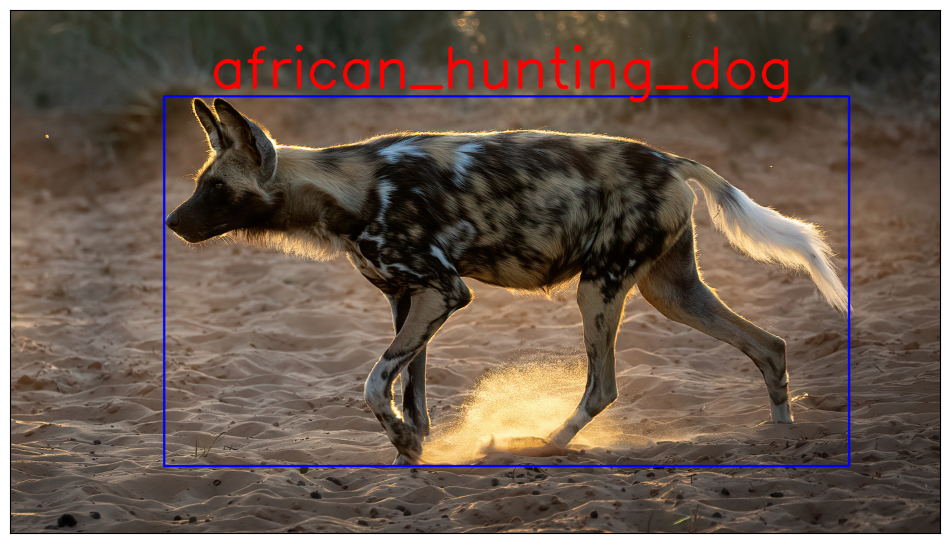

In [9]:
"""
Function to preprocess classification input:
  Before using the classification model, the image needs to be processed. 
  Resizing, normalizing, and adding dimensions are general steps.
  Each model expects a fixed image size, and it is decided before training.
  Here, I trained my model with 180x180 images,
  which is why in the preprocess_image function, I am resizing it to 180x180. 
"""
def preprocess_image(image, target_size):
    img = cv2.resize(image, target_size)  # Resize to target size
    img = img.astype('float32') / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Perform inference
def classify_region(image, model, target_size=(180, 180)):  # Size must match the classification model's input
    input_image = preprocess_image(image, target_size)
    predictions = model.predict(input_image)
    predicted_index = np.argmax(predictions[0])
    predicted_label = species_list[predicted_index]
    return predicted_label

# Load the image
image_path = r"images/dog1.jpg"  # Path to your image
image = cv2.imread(image_path)

# YOLO inference --> Object Detection Model
results = yolo_model(image)
detections = results[0].boxes  # Get detections

# Check YOLO label for "dog" and process the bounding boxes
for detection in detections:
    x1, y1, x2, y2 = map(int, detection.xyxy[0].tolist())  # Get bbox coordinates
    conf = float(detection.conf[0])  # Get confidence
    cls_label = yolo_model.names[int(detection.cls[0])]  # Get the label name directly from YOLO

    # Check if the label is "dog"
    if cls_label == "dog":

        """
        Extract the region of interest for classification.
        Remember, the image classification model will perform 
        only on the detected objects, not on the entire image.
        """
        roi = image[y1:y2, x1:x2]

        # Classify the ROI if it's large enough
        if roi.shape[0] > 0 and roi.shape[1] > 0:
            # Image Classification Model
            label = classify_region(roi, classification_model)

            bbox_height = y2 - y1
            font_scale = bbox_height / 200.0  # Scale factor, adjust as needed
            font_thickness = max(1, int(bbox_height / 100))  # Ensure thickness is at least 1

            # Draw the bounding box and label
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 4)
            cv2.putText(image, label, (x1+100, y1-20), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 255), font_thickness)
            print(f"Detected dog breed: {label}")

# save result
cv2.imwrite("result.jpg",image)

# Display the resulting image
plt.figure(figsize=(12, 8))
plt.xticks([]), plt.yticks([])
plt.imshow((cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))